In [ ]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubun

In [ ]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [ ]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_AGP_All-POS.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [ ]:
df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------+
|text                                                                                                   |
+-------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                                                                           |
|Australia  Manufacture Covid19 Vaccine  give it   Citizens for free of cost AFP quotes Prime Minister  |
|CovidVaccine"                                                                                          |
|CoronavirusVaccine CoronaVaccine CovidVaccine Australia is doing very good                             |
|Deaths due  COVID19 in Affected Countries                                                              |
|Read More                                                                                              |
|  "                                          

In [ ]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [ ]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [ ]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|
|Australia  Manufa...|Australia  Manufa...|
|       CovidVaccine"|        CovidVaccine|
|CoronavirusVaccin...|CoronavirusVaccin...|
|Deaths due  COVID...|Deaths due  COVID...|
|          Read More |          Read More |
|                   "|                    |
|   Stay safe  di ...|   Stay safe  di ...|
|Most countries wi...|Most countries wi...|
|Great news s vacc...|Great news s vacc...|
|    Pharmaceutical "|     Pharmaceutical |
|The whole narrati...|The whole narrati...|
|Russia made world...|Russia made world...|
|Thank god its not...|Thank god its not...|
|Search chennai co...|Search chennai co...|
|CovidVaccine Covi...|CovidVaccine Covi...|
|Nearly 500 deaths...|Nearly 500 deaths...|
|Coronavirus India...|Coronavirus India...|
|  CoronavirusIndia "|   CoronavirusIndia |
|OMG EXPOSED COVID...|OMG EXPOSE

In [ ]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

95056

In [ ]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|
|Australia  Manufa...|Australia  Manufa...|[australia, , man...|[australia, , man...|
|       CovidVaccine"|        CovidVaccine|      [covidvaccine]|      [covidvaccine]|
|CoronavirusVaccin...|CoronavirusVaccin...|[coronavirusvacci...|[coronavirusvacci...|
|Deaths due  COVID...|Deaths due  COVID...|[deaths, due, , c...|[deaths, due, , c...|
|          Read More |          Read More |        [read, more]|              [read]|
|                   "|                    |                  []|                  []|
|   Stay safe  di ...|   Stay safe  di ...|[, , , stay, safe...|[, , , stay, safe...|
|Most countries wi...|Most countries wi...|[most, coun

In [ ]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [ ]:
model.getVectors().show(truncate=False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
vecs = model.getVectors()

In [ ]:
vecs.filter(vecs["word"] == "incident").show()

+--------+--------------------+
|    word|              vector|
+--------+--------------------+
|incident|[0.01781334169209...|
+--------+--------------------+



In [ ]:
#AGP TEST
vecs.filter(vecs["word"] == "rage").show()

+----+--------------------+
|word|              vector|
+----+--------------------+
|rage|[0.00414561713114...|
+----+--------------------+



In [ ]:
#AGP TEST
vecs.filter(vecs["word"] == "rage").show()


TypeError: ignored

In [ ]:
#AGP TEST
diff_vector = vecs['rage'] - vecs['incident']

In [ ]:
#AGP TEST
wv.most_similar(positive=[diff_vector])

In [89]:
import gensim
from gensim.models import KeyedVectors

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

In [90]:
#AGP TEST
# pretty print function
def pp(obj):
    print(pd.vecs(obj))
    
def analogy(vaccine, jab, shot):
    result = model.most_similar(negative=[vaccine], 
                                positive=[jab, shot])
    return result[0][0]

countries = ['unitedstates', 'uk', 'india']
slang = [analogy('us', 'vaccine', country) for country in countries]
pp(zip(countries,slang))

AttributeError: ignored

In [ ]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('dose', 0.7503109574317932),
 ('hubby', 0.6489570140838623),
 ('dosage', 0.6376672387123108),
 ('jab', 0.6304296851158142),
 ('fauciouchie', 0.6211254596710205),
 ('nanny', 0.6130287051200867),
 ('woohoo', 0.595460057258606),
 ('round', 0.5763334035873413),
 ('24hours', 0.5718528628349304),
 ('24hrs', 0.5551822185516357),
 ('grmas', 0.543628454208374),
 ('poke', 0.5432896614074707),
 ('yesterday', 0.5416391491889954),
 ('cried', 0.5414024591445923),
 ('covishieldvaccine', 0.5353155136108398),
 ('badge', 0.5303828120231628),
 ('pfizercovidvaccine', 0.5215917229652405),
 ('jag', 0.5204296708106995),
 ('yay', 0.5149334073066711),
 ('stepmom', 0.5130038261413574)]

In [ ]:
w2v = model.transform(final_df)

In [ ]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|[0.0,0.0,0.0,0.0,...|
|Australia  Manufa...|Australia  Manufa...|[australia, , man...|[australia, , man...|[-0.0109258217125...|
|       CovidVaccine"|        CovidVaccine|      [covidvaccine]|      [covidvaccine]|[0.07689990848302...|
|CoronavirusVaccin...|CoronavirusVaccin...|[coronavirusvacci...|[coronavirusvacci...|[-0.0284001991152...|
|Deaths due  COVID...|Deaths due  COVID...|[deaths, due, , c...|[deaths, due, , c...|[-0.0111463920911...|
|          Read More |          Read More |        [read, more]|              [read]|[-0.1836723983287...|
|                   "|               

In [ ]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [ ]:
w2v_clustering.show(truncate=False)

+-------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+-------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+-------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                   |features                                                                                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                 

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(6).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [ ]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.22759294270343466


In [ ]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(21)

for k in range(2,20):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.000000
2,4,0.087863
3,5,0.166169
4,6,0.227593
5,7,0.196641
6,8,0.194881
7,9,0.111016
8,10,0.120345
9,11,0.221581


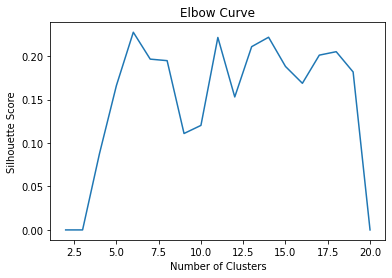

In [ ]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|        TEXT_CLEANED|[0.0,0.0,0.0,0.0,...|         3|
|Australia  Manufa...|[-0.1289945148965...|         1|
|       CovidVaccine"|[-2.0359524213260...|         5|
|CoronavirusVaccin...|[-0.3643822169387...|         1|
|Deaths due  COVID...|[-0.0840245453688...|         1|
|          Read More |[0.07265805166085...|         3|
|                   "|[0.0,0.0,0.0,0.0,...|         3|
|   Stay safe  di ...|[-0.1449231044527...|         0|
|Most countries wi...|[-0.0058652715513...|         3|
|Great news s vacc...|[-0.0734836234111...|         3|
|    Pharmaceutical "|[0.34478695639833...|         3|
|The whole narrati...|[-0.1127571512945...|         3|
|Russia made world...|[-0.1972806473019...|         1|
|Thank god its not...|[-0.0526002697418...|         2|
|Search chennai co...|[0.08567764435398...|         1|
|CovidVacc

In [ ]:
predictions.filter("prediction=0").show(75, truncate=False)

+----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                      |features                                                                                                                                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|   